#Fine-tuning Transformers

##Installing and Importing Libraries

In [0]:
USE_BUCKET = True #@param {type:"boolean"}

if USE_BUCKET:
  from google.colab import auth
  auth.authenticate_user()

In [0]:
!rm -rf outputs runs

In [2]:
!pip install pytorch_transformers
!pip install tensorboardX
!gsutil cp gs://qatar_competition/utils.py ./

     |████████████████████████████████| 184kB 6.5MB/s 
     |████████████████████████████████| 645kB 42.6MB/s 
     |████████████████████████████████| 860kB 33.5MB/s 
     |████████████████████████████████| 1.0MB 50.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=09c7a8e4c79f75959c512d675278f2adaf8775e52e5562587efdfe20ddf28279
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses
     |████████████████████████████████| 194kB 6.5MB/s 
Copying gs://qatar_competition/utils.py...
/ [1 files][ 13.3 KiB/ 13.3 KiB]                                                
Operation completed over 1 objects/13.3 KiB.                                     


In [26]:
!mkdir data
!gsutil cp -r gs://qatar_competition/data ./

Copying gs://qatar_competition/data/all_test.csv...
Copying gs://qatar_competition/data/all_test.tsv...
Copying gs://qatar_competition/data/all_test_clean.csv...
\ [3 files][107.0 KiB/107.0 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://qatar_competition/data/all_test_clean.tsv...
Copying gs://qatar_competition/data/all_training.csv...
Copying gs://qatar_competition/data/all_training.tsv...
Copying gs://qatar_competition/data/all_training_clean.csv...
Copying gs://qatar_competition/data/all_training_clean.tsv...
Copying gs://qatar_competition/data/dev.tsv...
Copying gs://qatar_competition/data/fake_test.csv...
Copying gs://qatar_competition/data/fake_training.csv...
Copying gs://qatar_competition/data/legit_test.csv...


In [4]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Writing setup.sh


In [5]:
!sh setup.sh

Cloning into 'apex'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 5550 (delta 4), reused 4 (delta 2), pack-reused 5531
Receiving objects: 100% (5550/5550), 13.36 MiB | 13.43 MiB/s, done.
Resolving deltas: 100% (3584/3584), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-gu4h4tvx
Created temporary directory: /tmp/pip-req-tracker-j29jaa47
Created requirements tracker '/tmp/pip-req-tracker-j29jaa47'
Created temporary directory: /tmp/pip-install-gkwxjcjm
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-dikvqq16
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-j29jaa47'
    Running setup.py (

In [0]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange
from tensorboardX import SummaryWriter


from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)

from pytorch_transformers import AdamW, WarmupLinearSchedule

from utils import (convert_examples_to_features,
                        output_modes, processors)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

##Initializing Arguments

In [0]:
args = {
    'data_dir': 'data/',
    'model_type':  'xlnet',
    'model_name': 'xlnet-base-cased',
    'task_name': 'binary',
    'output_dir': 'outputs/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': False,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 8,
    'eval_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'num_train_epochs': 10,
    'weight_decay': 0,
    'learning_rate': 2e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 20,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using Qatar Fake News dataset'
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
args_new = {
    'data_dir': 'data/',
    'model_type':  'xlnet',
    'model_name': 'xlnet-base-cased',
    'task_name': 'binary',
    'output_dir': 'outputs_xlnet_base/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': True,
    'fp16_opt_level': 'O1',
    'max_seq_length': 64,
    'output_mode': 'classification',
    'train_batch_size': 8,
    'eval_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'num_train_epochs': 10,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 20,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using Qatar Fake News dataset'
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
args

{'adam_epsilon': 1e-08,
 'cache_dir': 'cache/',
 'data_dir': 'data/',
 'do_eval': True,
 'do_train': True,
 'eval_all_checkpoints': True,
 'eval_batch_size': 8,
 'evaluate_during_training': False,
 'fp16': False,
 'fp16_opt_level': 'O1',
 'gradient_accumulation_steps': 1,
 'learning_rate': 2e-05,
 'logging_steps': 50,
 'max_grad_norm': 1.0,
 'max_seq_length': 128,
 'model_name': 'xlnet-base-cased',
 'model_type': 'xlnet',
 'notes': 'Using Qatar Fake News dataset',
 'num_train_epochs': 10,
 'output_dir': 'outputs/',
 'output_mode': 'classification',
 'overwrite_output_dir': False,
 'reprocess_input_data': True,
 'save_steps': 20,
 'task_name': 'binary',
 'train_batch_size': 8,
 'warmup_steps': 0,
 'weight_decay': 0}

In [0]:
with open('args.json', 'w') as f:
    json.dump(args, f)

In [0]:
if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [0]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

##Importing Models

In [33]:
config = config_class.from_pretrained(args['model_name'], num_labels=2, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model from cache at /root/.cache/torch/pytorch_transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc9ecd464419b3bf921864a355ba807cfbfafa8


In [34]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
model = model_class.from_pretrained(args['model_name'])

In [0]:
model.to(device);

In [0]:
task = args['task_name']

if task in processors.keys() and task in output_modes.keys():
    processor = processors[task]()
    label_list = processor.get_labels()
    num_labels = len(label_list)
else:
    raise KeyError(f'{task} not found in processors or in output_modes. Please check utils.py.')

##Defining Utility Functions

In [0]:
def load_and_cache_examples(task, tokenizer, mode="train"):
    processor = processors[task]()
    output_mode = args['output_mode']
    
    #mode = 'dev' if evaluate else 'train'
    cached_features_file = os.path.join(args['data_dir'], f"cached_{mode}_{args['model_name']}_{args['max_seq_length']}_{task}")
    
    if os.path.exists(cached_features_file) and not args['reprocess_input_data']:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
               
    else:
        logger.info("Creating features from dataset file at %s", args['data_dir'])
        label_list = processor.get_labels()
        if mode=="train":
          examples=processor.get_train_examples(args['data_dir']);
        if mode=="dev":
          examples=processor.get_dev_examples(args['data_dir']);
        if mode=="predict":
          examples=processor.get_predict_examples(args['data_dir'])
        #examples = processor.get_dev_examples(args['data_dir']) if evaluate else processor.get_train_examples(args['data_dir'])
        
        if __name__ == "__main__":
            features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
                cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
                cls_token=tokenizer.cls_token,
                cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
                sep_token=tokenizer.sep_token,
                sep_token_extra=bool(args['model_type'] in ['roberta']),           # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0)
        
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
        
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [0]:
def train(train_dataset, model, tokenizer):
    tb_writer = SummaryWriter()
    
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])
    
    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args['warmup_steps'], t_total=t_total)
    
    if args['fp16']:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args['fp16_opt_level'])
        
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size  = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
    
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            print("\r%f" % loss, end='')

            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args['max_grad_norm'])
                
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

            tr_loss += loss.item()
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1

                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    # Log metrics
                    if args['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                    tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
                    logging_loss = tr_loss

                if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)


    return global_step, tr_loss / global_step

In [0]:
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix, classification_report
from scipy.stats import pearsonr

def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]
    
    return wrong

def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }, get_mismatched(labels, preds)

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def evaluate(model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args['output_dir']

    results = {}
    EVAL_TASK = args['task_name']

    eval_dataset = load_and_cache_examples(EVAL_TASK, tokenizer, mode="dev")
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)


    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
    results.update(result)
    cr = classification_report(out_label_ids,preds,target_names=["Legit","Fake"])
    output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return results, wrong , cr

In [0]:
def predict(model, tokenizer, prefix=""):
  pred_output_dir = args['output_dir']
  
  results={}
  PRED_TASK = args['task_name']
  
  pred_dataset = load_and_cache_examples(PRED_TASK, tokenizer, mode='predict')
  if not os.path.exists(pred_output_dir):
    os.makedirs(pred_output_dir)
    
  
  pred_sampler = SequentialSampler(pred_dataset)
  pred_dataloader = DataLoader(pred_dataset, sampler=pred_sampler, batch_size=args['eval_batch_size'])
  
  # Eval!
  logger.info("***** Running prediction {} *****".format(prefix))
  logger.info("  Num examples = %d", len(pred_dataset))
  logger.info("  Batch size = %d", args['eval_batch_size'])
  
  preds = None
  for batch in pred_dataloader:
    with torch.no_grad():
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids': batch[0],'attention_mask': batch[1],'token_type_ids': batch[2],'labels': batch[3]}
      
      outputs = model(**inputs)
      _, logits = outputs[:2]
    if preds is None:
        preds = logits.detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

  preds = np.argmax(preds, axis=1)
      
  return preds

##Training

In [43]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer , mode="train")
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

INFO:__main__:Creating features from dataset file at data/
100%|██████████| 384/384 [00:00<00:00, 956.38it/s]
INFO:__main__:Saving features into cached file data/cached_train_xlnet-base-cased_128_binary
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 384
INFO:__main__:  Num Epochs = 10
INFO:__main__:  Total train batch size  = 8
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 480
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

0.567550

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0.787257

INFO:__main__:Saving model checkpoint to outputs/checkpoint-20


0.658514

INFO:__main__:Saving model checkpoint to outputs/checkpoint-40


0.591535

Epoch:  10%|█         | 1/10 [00:31<04:40, 31.18s/it]

0.545504

INFO:__main__:Saving model checkpoint to outputs/checkpoint-60


0.314016

INFO:__main__:Saving model checkpoint to outputs/checkpoint-80


0.419260

Epoch:  20%|██        | 2/10 [01:02<04:09, 31.17s/it]

0.374991

INFO:__main__:Saving model checkpoint to outputs/checkpoint-100


0.029969

INFO:__main__:Saving model checkpoint to outputs/checkpoint-120


0.016938

INFO:__main__:Saving model checkpoint to outputs/checkpoint-140


1.122498

Epoch:  30%|███       | 3/10 [01:34<03:40, 31.53s/it]

0.003158

INFO:__main__:Saving model checkpoint to outputs/checkpoint-160


0.014062

INFO:__main__:Saving model checkpoint to outputs/checkpoint-180


0.008950

Epoch:  40%|████      | 4/10 [02:06<03:09, 31.51s/it]

0.283394

INFO:__main__:Saving model checkpoint to outputs/checkpoint-200


0.081107

INFO:__main__:Saving model checkpoint to outputs/checkpoint-220


0.001798

INFO:__main__:Saving model checkpoint to outputs/checkpoint-240
Epoch:  50%|█████     | 5/10 [02:38<02:38, 31.76s/it]

0.004952

INFO:__main__:Saving model checkpoint to outputs/checkpoint-260


0.000621

INFO:__main__:Saving model checkpoint to outputs/checkpoint-280


0.000547

Epoch:  60%|██████    | 6/10 [03:09<02:06, 31.64s/it]

0.000612

INFO:__main__:Saving model checkpoint to outputs/checkpoint-300


0.000413

INFO:__main__:Saving model checkpoint to outputs/checkpoint-320


0.000410

Epoch:  70%|███████   | 7/10 [03:41<01:34, 31.54s/it]

0.000741

INFO:__main__:Saving model checkpoint to outputs/checkpoint-340


0.000526

INFO:__main__:Saving model checkpoint to outputs/checkpoint-360


0.000263

INFO:__main__:Saving model checkpoint to outputs/checkpoint-380


0.000542

Epoch:  80%|████████  | 8/10 [04:13<01:03, 31.70s/it]

0.000433

INFO:__main__:Saving model checkpoint to outputs/checkpoint-400


0.335676

INFO:__main__:Saving model checkpoint to outputs/checkpoint-420


0.000164

Epoch:  90%|█████████ | 9/10 [04:44<00:31, 31.50s/it]

0.000313

INFO:__main__:Saving model checkpoint to outputs/checkpoint-440


0.000157

INFO:__main__:Saving model checkpoint to outputs/checkpoint-460


0.000238

INFO:__main__:Saving model checkpoint to outputs/checkpoint-480
Epoch: 100%|██████████| 10/10 [05:16<00:00, 31.75s/it]
INFO:__main__: global_step = 480, average loss = 0.2123041375928248


In [0]:
if args['do_train']:
    if not os.path.exists(args['output_dir']):
            os.makedirs(args['output_dir'])
    logger.info("Saving model checkpoint to %s", args['output_dir'])
    
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args['output_dir'])
    tokenizer.save_pretrained(args['output_dir'])
    torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))

INFO:__main__:Saving model checkpoint to outputs/


##Evaluating

In [0]:
!mkdir outputs_xlnet_base
!gsutil -m cp -r gs://qatar_competition/outputs_xlnet_base/ ./

In [0]:
!cp data_fake_eval/dev.tsv data/dev.tsv

In [0]:
results_1 = results

In [0]:
def get_num(file_name):
  s= file_name.split('-')[-1]
  if s=='outputs_xlnet_base/outputs':
    return 99999
  return int(s)

results = {}
results_cr = []
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in sorted(checkpoints,reverse = False,key=get_num):
        print(checkpoint)
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        model = model_class.from_pretrained(checkpoint)
        model.to(device)
        with torch.no_grad():
          result, wrong_preds,cr = evaluate(model, tokenizer, prefix=global_step)
          result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
          results.update(result)
          results_cr.append(cr)
          print(cr)
        model.cpu()
        del model
        torch.cuda.empty_cache()

INFO:__main__:Evaluate the following checkpoints: ['outputs/checkpoint-100', 'outputs/checkpoint-120', 'outputs/checkpoint-140', 'outputs/checkpoint-160', 'outputs/checkpoint-180', 'outputs/checkpoint-20', 'outputs/checkpoint-200', 'outputs/checkpoint-220', 'outputs/checkpoint-240', 'outputs/checkpoint-260', 'outputs/checkpoint-280', 'outputs/checkpoint-300', 'outputs/checkpoint-320', 'outputs/checkpoint-340', 'outputs/checkpoint-360', 'outputs/checkpoint-380', 'outputs/checkpoint-40', 'outputs/checkpoint-400', 'outputs/checkpoint-420', 'outputs/checkpoint-440', 'outputs/checkpoint-460', 'outputs/checkpoint-480', 'outputs/checkpoint-60', 'outputs/checkpoint-80']


outputs/checkpoint-20


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 49/49 [00:00<00:00, 398.56it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 20 *****
INFO:__main__:  Num examples = 49
INFO:__main__:  Batch size = 8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
INFO:__main__:***** Eval results 20 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 24
INFO:__main__:  mcc = 0.0
INFO:__main__:  tn = 0
INFO:__main__:  tp = 25



              precision    recall  f1-score   support

       Legit       0.00      0.00      0.00        24
        Fake       0.51      1.00      0.68        25

    accuracy                           0.51        49
   macro avg       0.26      0.50      0.34        49
weighted avg       0.26      0.51      0.34        49

outputs/checkpoint-40


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 49/49 [00:00<00:00, 394.67it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 40 *****
INFO:__main__:  Num examples = 49
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 40 *****
INFO:__main__:  fn = 7
INFO:__main__:  fp = 8
INFO:__main__:  mcc = 0.38731272671062317
INFO:__main__:  tn = 16
INFO:__main__:  tp = 18



              precision    recall  f1-score   support

       Legit       0.70      0.67      0.68        24
        Fake       0.69      0.72      0.71        25

    accuracy                           0.69        49
   macro avg       0.69      0.69      0.69        49
weighted avg       0.69      0.69      0.69        49

outputs/checkpoint-60


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 49/49 [00:00<00:00, 378.77it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 60 *****
INFO:__main__:  Num examples = 49
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 60 *****
INFO:__main__:  fn = 7
INFO:__main__:  fp = 10
INFO:__main__:  mcc = 0.30641293851417056
INFO:__main__:  tn = 14
INFO:__main__:  tp = 18



              precision    recall  f1-score   support

       Legit       0.67      0.58      0.62        24
        Fake       0.64      0.72      0.68        25

    accuracy                           0.65        49
   macro avg       0.65      0.65      0.65        49
weighted avg       0.65      0.65      0.65        49

outputs/checkpoint-80


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 49/49 [00:00<00:00, 404.52it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 80 *****
INFO:__main__:  Num examples = 49
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 80 *****
INFO:__main__:  fn = 2
INFO:__main__:  fp = 11
INFO:__main__:  mcc = 0.5007478067980647
INFO:__main__:  tn = 13
INFO:__main__:  tp = 23



              precision    recall  f1-score   support

       Legit       0.87      0.54      0.67        24
        Fake       0.68      0.92      0.78        25

    accuracy                           0.73        49
   macro avg       0.77      0.73      0.72        49
weighted avg       0.77      0.73      0.72        49

outputs/checkpoint-100


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 49/49 [00:00<00:00, 389.66it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 100 *****
INFO:__main__:  Num examples = 49
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 100 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 12
INFO:__main__:  mcc = 0.520847435706514
INFO:__main__:  tn = 12
INFO:__main__:  tp = 24



              precision    recall  f1-score   support

       Legit       0.92      0.50      0.65        24
        Fake       0.67      0.96      0.79        25

    accuracy                           0.73        49
   macro avg       0.79      0.73      0.72        49
weighted avg       0.79      0.73      0.72        49

outputs/checkpoint-120


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 49/49 [00:00<00:00, 387.59it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 120 *****
INFO:__main__:  Num examples = 49
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 120 *****
INFO:__main__:  fn = 3
INFO:__main__:  fp = 10
INFO:__main__:  mcc = 0.4865973291997335
INFO:__main__:  tn = 14
INFO:__main__:  tp = 22



              precision    recall  f1-score   support

       Legit       0.82      0.58      0.68        24
        Fake       0.69      0.88      0.77        25

    accuracy                           0.73        49
   macro avg       0.76      0.73      0.73        49
weighted avg       0.75      0.73      0.73        49

outputs/checkpoint-140


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 49/49 [00:00<00:00, 411.39it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 140 *****
INFO:__main__:  Num examples = 49
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 140 *****
INFO:__main__:  fn = 7
INFO:__main__:  fp = 7
INFO:__main__:  mcc = 0.42833333333333334
INFO:__main__:  tn = 17
INFO:__main__:  tp = 18



              precision    recall  f1-score   support

       Legit       0.71      0.71      0.71        24
        Fake       0.72      0.72      0.72        25

    accuracy                           0.71        49
   macro avg       0.71      0.71      0.71        49
weighted avg       0.71      0.71      0.71        49

outputs/checkpoint-160


In [0]:
file_name="outputs_xlnet_base/outputs"
s= file_name.split('-')[-1]
print(s)

outputs_xlnet_base/outputs


In [0]:
results

{}

In [0]:
def get_result_from_results(resutls,step="outputs"):
  fn = results["fn_"+str(step)]
  fp = results["fp_"+str(step)]
  mcc = results["mcc_"+str(step)]
  tn = results["tn_"+str(step)]
  tp = results["tp_"+str(step)]  
  return {"fn":fn,"fp":fp,"mcc":mcc,"tn":tn,"tp":tp}

def get_metrics(res):
  precision = res["tp"]/(res["fp"]+res["tp"])
  recall = res["tp"]/(res["fn"]+res["tp"])
  accuracy = (res["tp"]+res["tn"])/(res["fn"]+res["tp"]+res["tn"]+res["fp"])
  specificity = res["tn"]/(res["tn"]+res["fp"])
  f1 = (2*precision*recall)/(precision+recall)
  return precision,recall,accuracy,specificity,f1

In [0]:
res = get_result_from_results(results,"10")

In [0]:
precision,recall,accuracy,specificity,f1 = get_metrics(res)

print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("Accuracy: "+str(accuracy))
print("Specificity: "+str(specificity))
print("F1: "+str(f1))

Precision: 1.0
Recall: 1.0
Accuracy: 1.0
Specificity: 1.0
F1: 1.0


In [0]:
p=[]
r=[]
a=[]
s=[]
f=[]
for i in range(20,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"]):
  res = get_result_from_results(results,i)
  precision,recall,accuracy,specificity,f1 = get_metrics(res)
  p.append(precision)
  r.append(recall)
  a.append(accuracy)
  s.append(specificity)
  f.append(f1)

In [0]:
res = get_result_from_results(results,"outputs")
precision,recall,accuracy,specificity,f1 = get_metrics(res)
p.append(precision)
r.append(recall)
a.append(accuracy)
s.append(specificity)
f.append(f1)

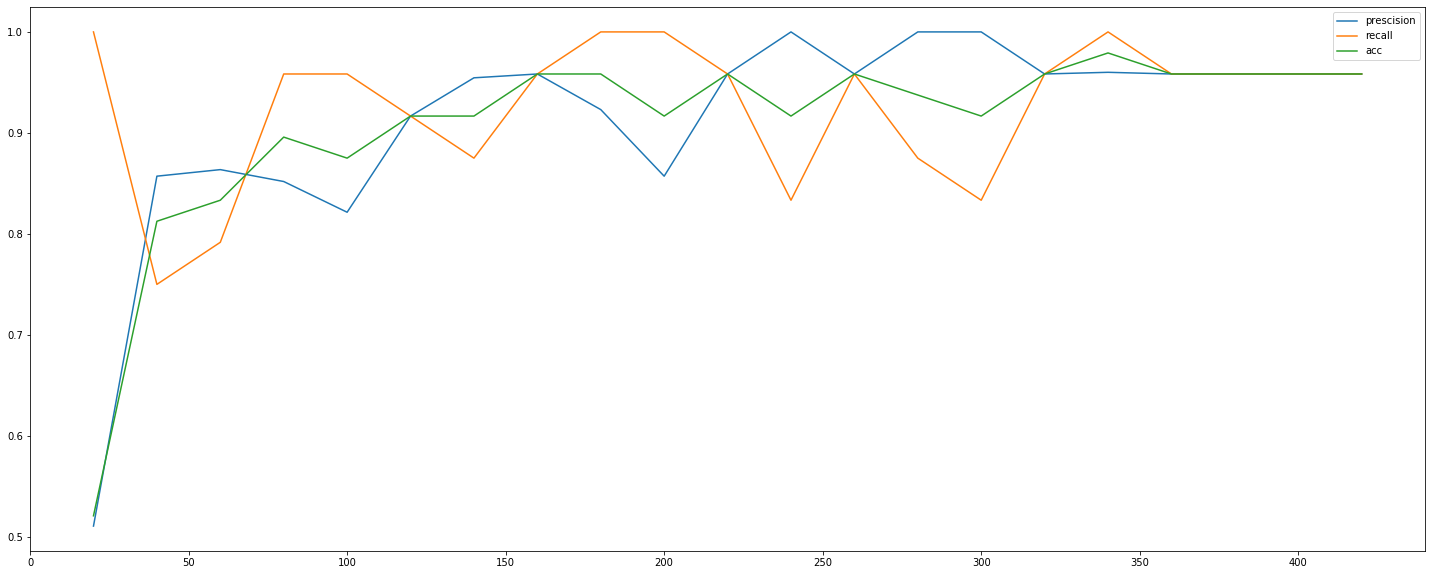

In [47]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [25, 10]

x= range(20,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"])
plt.plot(x,p,label="prescision")
plt.plot(x,r,label="recall")
plt.plot(x,a,label="acc")
#plt.plot(x,s,label="spec")
#plt.plot(x,f,label="f1")
plt.legend()
plt.show()


In [0]:
!cp ./data/dev.tsv

##Predictions

In [0]:
checkpoints = [args['output_dir']]
if args['eval_all_checkpoints']:
    checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
    logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
logger.info("Evaluate the following checkpoints: %s", checkpoints)
for checkpoint in checkpoints:
    global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
    model = model_class.from_pretrained(checkpoint)
    model.to(device)
    preds = predict(model, tokenizer, prefix=global_step)

In [0]:
checkpoint='outputs/checkpoint-380'
global_step = checkpoint.split('-')[-1]
model = model_class.from_pretrained(checkpoint)
model.to(device)
preds = predict(model, tokenizer, prefix=global_step)

INFO:pytorch_transformers.modeling_utils:loading configuration file outputs/checkpoint-380/config.json
INFO:pytorch_transformers.modeling_utils:Model config {
  "attn_type": "bi",
  "bi_data": false,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "ff_activation": "gelu",
  "finetuning_task": null,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "n_head": 12,
  "n_layer": 12,
  "n_token": 32000,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "torchscript": false,
  "untie_r": true
}

INFO:pytorch_transformers.modeling_utils:loading weights file outputs/checkpoint-380/pytorch_model.bin
INFO:__main__:Creating features from dataset file at data_fake_eval/
100%|██

In [0]:
print(preds)

[0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0
 0 0 1 0 0 1 0 1 1 0 1 0]


In [0]:
!gsutil cp gs://qatar_competition/Submission_with_domain.csv ./

Copying gs://qatar_competition/Submission_with_domain.csv...
- [1 files][  1.3 KiB/  1.3 KiB]                                                
Operation completed over 1 objects/1.3 KiB.                                      


In [0]:
import pandas as pd
df_sub = pd.read_csv('Submission_with_domain.csv')

In [0]:
df_sub.head()

,File Name,Fake,Domain
0,asd03.blind.txt,NaN,Education
1,asd01.blind.txt,NaN,Education
2,qwe02.blind.txt,NaN,Business
3,poi03.blind.txt,NaN,Business
4,bsb04.blind.txt,NaN,Business


In [0]:
df_sub["Fake"]=preds

In [0]:
df_sub.head()

,File Name,Fake,Domain
0,asd03.blind.txt,0,Education
1,asd01.blind.txt,0,Education
2,qwe02.blind.txt,0,Business
3,poi03.blind.txt,1,Business
4,bsb04.blind.txt,0,Business


In [0]:
df_sub.to_csv("AI_Musketeers_Task1A.csv",index=False)

In [0]:
!gsutil cp AI_Musketeers_Task1A.csv gs://qatar_competition/

Copying file://AI_Musketeers_Task1A.csv [Content-Type=text/csv]...
/ [1 files][  1.4 KiB/  1.4 KiB]                                                
Operation completed over 1 objects/1.4 KiB.                                      


In [0]:
for checkpoint in checkpoints:
  global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
  model = model_class.from_pretrained(checkpoint)
  model.to(device)
  result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
  result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
  results.update(result)


In [0]:
!gsutil -m cp -r ./outputs gs://qatar_competition/outputs_xlnet_base_10epochs_384seq_len_fake_news/

Copying file://./outputs/checkpoint-180/config.json [Content-Type=application/json]...
Copying file://./outputs/checkpoint-80/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs/checkpoint-180/pytorch_model.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://./outputs/checkpoint-

In [0]:
!mv ./data/train.tsv ./data/temp.tsv
!mv ./data/dev.tsv ./data/train.tsv
!mv ./data/temp.tsv ./data/dev.tsv